In [21]:
import nltk
from nltk.corpus import stopwords
from collections import Counter
import string
import kagglehub
from kagglehub import KaggleDatasetAdapter

import pandas as pd
import json
import torch
from tabulate import tabulate
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Download NLTK stopwords if not already downloaded
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/chi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [22]:
# Load the dataset
file_path = "data/IMDB_reviews.json"

data = []
with open(file_path, 'r') as file:
    for line in file:
        data.append(json.loads(line))

df = pd.DataFrame(data)


In [23]:
# get dataset info
info = df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 573913 entries, 0 to 573912
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   review_date     573913 non-null  object
 1   movie_id        573913 non-null  object
 2   user_id         573913 non-null  object
 3   is_spoiler      573913 non-null  bool  
 4   review_text     573913 non-null  object
 5   rating          573913 non-null  object
 6   review_summary  573913 non-null  object
dtypes: bool(1), object(6)
memory usage: 26.8+ MB


In [24]:
# Describe the dataset
description = df.describe()


# Check for missing values
missing_values = df.isnull().sum()


# Distribution of spoiler vs. non-spoiler
spoiler_distribution = df['is_spoiler'].value_counts(normalize=True)

# Length of reviews
df['review_length'] = df['review_text'].apply(len)
review_length_description = df['review_length'].describe()

print("\nMissing Values:")
print(tabulate(missing_values.items(), headers=["Column", "Missing Values"], tablefmt="pretty"))

print("\nSpoiler vs. Non-Spoiler Distribution:")
print(tabulate(spoiler_distribution.items(), headers=["Is Spoiler", "Proportion"], tablefmt="pretty"))

print("\nReview Length Description:")
print(tabulate(review_length_description.items(), headers=["Statistic", "Value"], tablefmt="pretty"))


Missing Values:
+----------------+----------------+
|     Column     | Missing Values |
+----------------+----------------+
|  review_date   |       0        |
|    movie_id    |       0        |
|    user_id     |       0        |
|   is_spoiler   |       0        |
|  review_text   |       0        |
|     rating     |       0        |
| review_summary |       0        |
+----------------+----------------+

Spoiler vs. Non-Spoiler Distribution:
+------------+---------------------+
| Is Spoiler |     Proportion      |
+------------+---------------------+
|   False    | 0.7370263437141169  |
|    True    | 0.26297365628588304 |
+------------+---------------------+

Review Length Description:
+-----------+--------------------+
| Statistic |       Value        |
+-----------+--------------------+
|   count   |      573913.0      |
|   mean    | 1460.5535246631457 |
|    std    | 1125.577018615146  |
|    min    |        18.0        |
|    25%    |       719.0        |
|    50%    |     

In [28]:
# Plot some samples of the dataset
sample_size = 10

spoiler_samples = df[df['is_spoiler'] == True].sample(sample_size)
non_spoiler_samples = df[df['is_spoiler'] == False].sample(sample_size)

plt.figure(figsize=(100, 50))

# Spoiler samples
for i, review in enumerate(spoiler_samples['review_text']):
    plt.text(0.5, 1.0 - i*0.2, f"Spoiler Review {i+1}: {review[:150]}...", ha='center', va='top', wrap=True)

# Non-Spoiler samples
for i, review in enumerate(non_spoiler_samples['review_text']):
    plt.text(0.5, 0.5 - i*0.2, f"Non-Spoiler Review {i+1}: {review[:150]}...", ha='center', va='top', wrap=True)

plt.axis('off')
plt.title('Sample Reviews (Spoiler vs Non-Spoiler)')
plt.show()

/var/folders/4x/qtt50c_16_j8ntstjbyx20v40000gn/T/ipykernel_71678/2552334151.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='is_spoiler', data=df, palette='coolwarm')


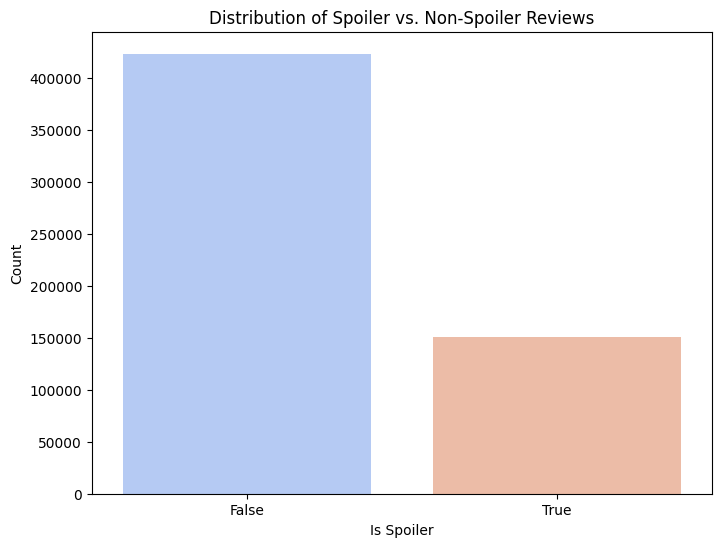

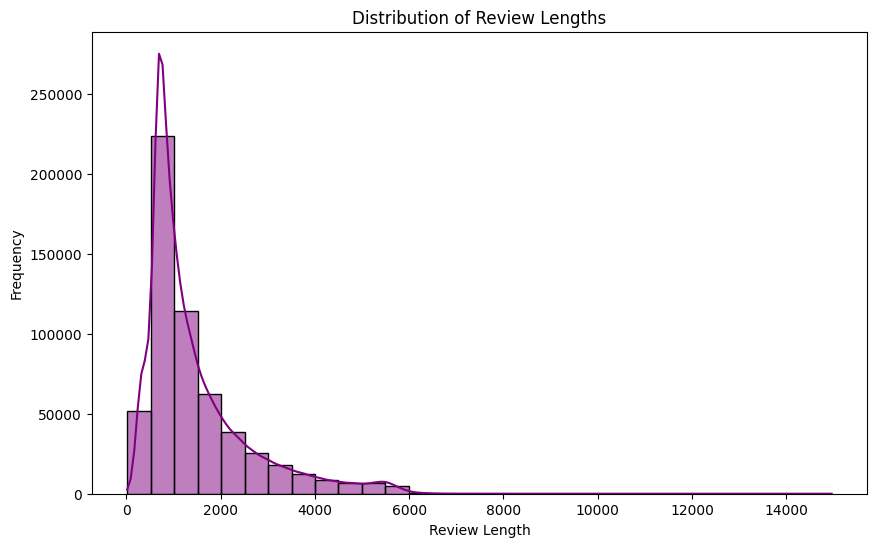

/var/folders/4x/qtt50c_16_j8ntstjbyx20v40000gn/T/ipykernel_71678/2552334151.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_spoiler', y='review_length', data=df, palette='coolwarm')


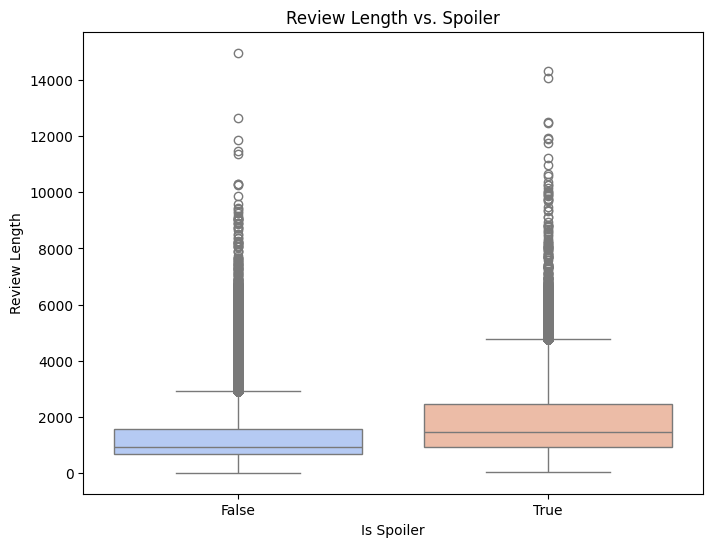

In [29]:
# Plot distribution of spoilers vs. non-spoilers
plt.figure(figsize=(8, 6))
sns.countplot(x='is_spoiler', data=df, palette='coolwarm')
plt.title('Distribution of Spoiler vs. Non-Spoiler Reviews')
plt.xlabel('Is Spoiler')
plt.ylabel('Count')
plt.show()

# Plot the distribution of review lengths
plt.figure(figsize=(10, 6))
sns.histplot(df['review_length'], kde=True, bins=30, color='purple')
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.show()

# Correlation between review length and is_spoiler
plt.figure(figsize=(8, 6))
sns.boxplot(x='is_spoiler', y='review_length', data=df, palette='coolwarm')
plt.title('Review Length vs. Spoiler')
plt.xlabel('Is Spoiler')
plt.ylabel('Review Length')
plt.show()

In [30]:
# Assuming 'df' is your DataFrame and it has been preprocessed with 'is_spoiler' and 'cleaned_review_text' columns

# Step 1: Identify the class counts
class_counts = df['is_spoiler'].value_counts()
min_class_count = class_counts.min()  # Get the count of the minority class

# Step 2: Separate the classes
df_class_0 = df[df['is_spoiler'] == 0]
df_class_1 = df[df['is_spoiler'] == 1]

# Step 3: Downsample the majority class
df_class_0_downsampled = df_class_0.sample(min_class_count, random_state=42)  # Use random_state for reproducibility
df_class_1_downsampled = df_class_1.sample(min_class_count, random_state=42)  # Ensuring it's already the minority size

# Step 4: Concatenate the results
df_balanced = pd.concat([df_class_0_downsampled, df_class_1_downsampled])

# Step 5: Shuffle the dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Replace the initial DataFrame with the balanced DataFrame
df = df_balanced

# Display the new class distribution and a few rows to verify
print(df['is_spoiler'].value_counts())
print(df.head())

is_spoiler
False    150924
True     150924
Name: count, dtype: int64
        review_date   movie_id     user_id  is_spoiler  \
0     5 August 2006  tt0415306  ur11723253       False   
1      20 July 2007  tt0482571   ur8387182       False   
2    3 January 2014  tt0113189  ur45796763       False   
3      24 June 2012  tt0120201   ur1994077        True   
4  13 December 2011  tt0170016  ur25851619        True   

                                         review_text rating  \
0  This was the funniest movie I've ever seen. Sa...     10   
1  It's a long time since I saw a film where I wa...      9   
2  Where to start? an absolute classic, a film th...     10   
3  I haven't read Heinlein's original novel, so I...      5   
4  After the 1966 Animated short people were in t...     10   

                                      review_summary  review_length  
0  "If you're not the winner, you're the loser," ...            886  
1                   Surprising and thought-provoking           

/var/folders/4x/qtt50c_16_j8ntstjbyx20v40000gn/T/ipykernel_71678/2552334151.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='is_spoiler', data=df, palette='coolwarm')


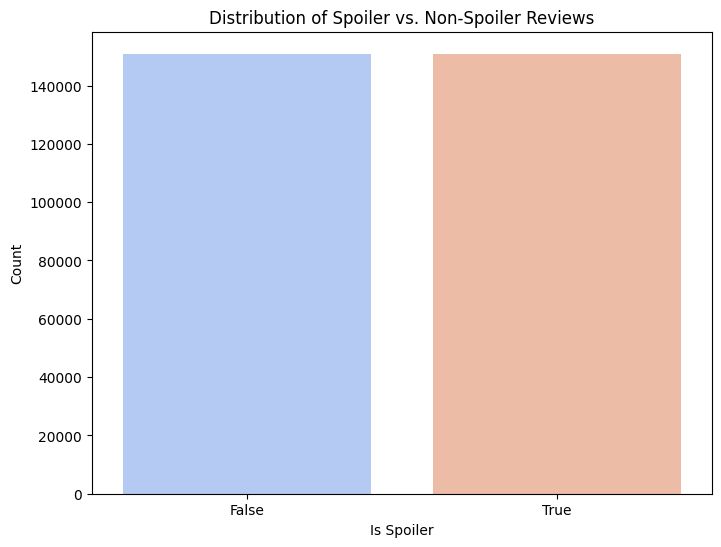

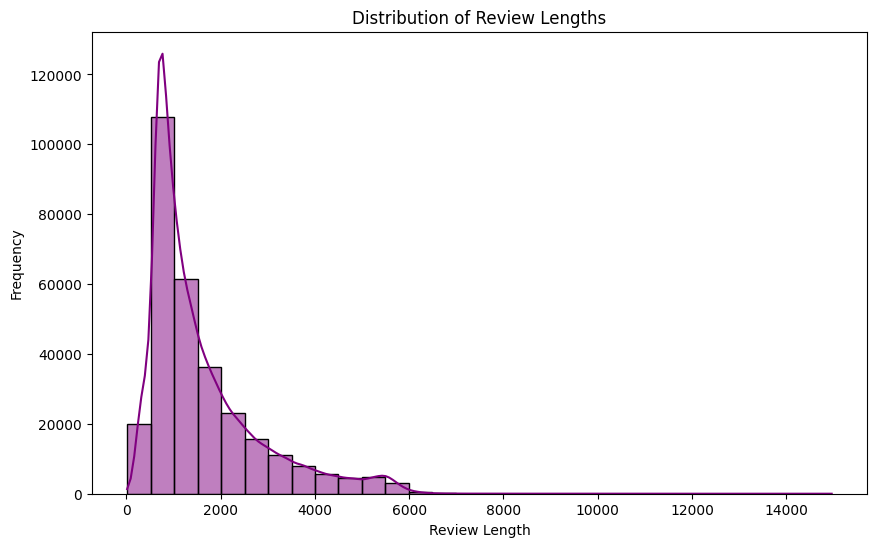

/var/folders/4x/qtt50c_16_j8ntstjbyx20v40000gn/T/ipykernel_71678/2552334151.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_spoiler', y='review_length', data=df, palette='coolwarm')


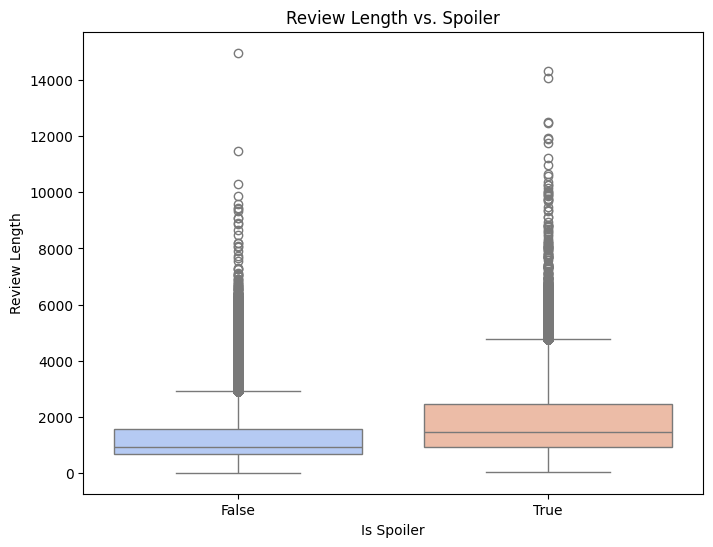

In [31]:
# Plot distribution of spoilers vs. non-spoilers
plt.figure(figsize=(8, 6))
sns.countplot(x='is_spoiler', data=df, palette='coolwarm')
plt.title('Distribution of Spoiler vs. Non-Spoiler Reviews')
plt.xlabel('Is Spoiler')
plt.ylabel('Count')
plt.show()

# Plot the distribution of review lengths
plt.figure(figsize=(10, 6))
sns.histplot(df['review_length'], kde=True, bins=30, color='purple')
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.show()

# Correlation between review length and is_spoiler
plt.figure(figsize=(8, 6))
sns.boxplot(x='is_spoiler', y='review_length', data=df, palette='coolwarm')
plt.title('Review Length vs. Spoiler')
plt.xlabel('Is Spoiler')
plt.ylabel('Review Length')
plt.show()